In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys # used in command to make entire array print by default
import seaborn as sns

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

In [2]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict




def linreg(X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_train)
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(x = y_train.recovery, y = y_pred.ravel())
    reg_df = pd.DataFrame(lr.coef_, columns=X_vars)
    reg_df = reg_df.transpose().sort_values(by=0, ascending=False)
    reg_df.rename(index=str, columns={0: 'value'}, inplace=True)
    abs_df = reg_df.copy()
    abs_df['value'] = abs(abs_df['value'])
    abs_df.sort_values(by='value', ascending=False)
    return reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter

def ridge(X_train, y_train):
    rr = Ridge(alpha=.5)
    rr.fit(X_train, y_train)
    y_pred = rr.predict((X_train))
    MAE = median_absolute_error(y_train, y_pred)
    MSE = mean_squared_error(y_train, y_pred)
    scatter = sns.scatterplot(y_train, y_pred)
    return rr, rr.coef_, rr.intercept_, MAE, MSE, y_pred, scatter

def svm(X_train, y_train):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
    y_rbf = svr_rbf.fit(X_train, y_train).predict(X_train)
    y_lin = svr_lin.fit(X_train, y_train).predict(X_train)
    y_poly = svr_poly.fit(X_train, y_train).predict(X_train)
    MSE_rbf = mean_squared_error(y_train, y_rbf)
    MSE_lin = mean_squared_error(y_train, y_lin)
    MSE_poly = mean_squared_error(y_train, y_poly)
    return svr_rbf, svr_lin, svr_poly, MSE_rbf, MSE_lin, MSE_poly, y_rbf, y_lin, y_poly

In [3]:
df = acquire_oil()
df = prep_data(df)
df.reset_index(inplace=True)
df.shape

(7882, 38)

In [4]:
df.isnull().sum()

index                   0
api14                   0
lease_name              0
well_number             0
county                  0
type                    0
status                  0
oper                    0
multi_well_lease        0
major_phase             0
formation               0
proppant_ppf            0
prod_method             0
frac_fluid_gpf          0
lateral_len             0
frac_stages           305
frac_fluid_type         0
first_prod              0
last_prod               0
oil_gravity           154
peak_boepd              0
oil_hist                0
gas_hist                0
gor_hist                0
ip90_boeqpd             0
landing_depth           2
sur_lat                 0
sur_long                0
well_id                 0
mid_point_lat           0
mid_point_long          0
recovery                0
recovery_per_foot       0
months_active           0
recovery_per_month      0
lateral_class           0
vintage                 0
vintage_bin             0
dtype: int64

In [5]:
df.drop(columns=['api14', 'sur_lat', 'sur_long', 'well_id', 'mid_point_lat', 
                 'mid_point_long', 'landing_depth']).describe()

,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,oil_hist,gas_hist,gor_hist,ip90_boeqpd,recovery,recovery_per_foot,months_active,recovery_per_month,vintage,vintage_bin
count,7882.000000,7882.000000,7882.000000,7577.000000,7728.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000,7882.000000
mean,1129.548086,1142.623297,5733.308044,3.295895,1.888571,508.757122,120.116291,385.185382,3887.156777,349.260675,152.165770,36.229053,60.247019,inf,2011.734331,4.485537
std,656.559342,714.343615,2945.929989,9.512917,9.249698,443.658160,95.672470,386.629549,3811.727264,315.139560,140.335763,61.395236,60.101545,NaN,8.204480,0.781142
min,1.098097,0.354610,4.000000,0.000000,0.000000,0.663017,0.031000,0.001000,0.212134,0.001812,0.013000,0.002991,0.000000,0.590909,1958.000000,1.000000
25%,526.086415,499.580950,4057.250000,0.000000,0.000000,159.841973,46.527750,110.837500,1424.770202,94.923915,57.775961,14.011005,32.000000,1072.513250,2012.000000,4.000000
50%,1156.695495,1223.013980,6242.000000,0.000000,0.000000,429.196850,101.302000,284.693500,2491.670655,292.435684,125.208592,22.250498,49.000000,2689.522044,2014.000000,5.000000
75%,1595.116423,1653.277683,7723.750000,0.000000,0.000000,732.486175,172.355750,542.437000,4905.822000,508.763271,196.367385,36.953621,66.000000,4947.528030,2015.000000,5.000000
max,3969.384520,2997.879640,13581.000000,70.000000,68.000000,6118.757000,754.662000,4007.768000,19968.130000,4752.926000,999.305470,997.824074,726.000000,inf,2018.000000,5.000000


## Standardize Numeric Data

In [6]:
numerics = ['int64', 'float64']

num_df = df.select_dtypes(include=numerics)
num_df = num_df.drop(columns=['gas_hist', 'recovery_per_foot', 
                              'recovery_per_month', 'api14',
#                              'landing_depth', sur_long', 'sur_lat', 'mid_point_lat', 'mid_point_long',
                             'well_id', 'oil_hist'])

### Use LabelEncoder to encode county, frac_fluid_type, oper, type, and formation.

In [7]:
for col in ['county', 'frac_fluid_type', 'oper', 'type', 'formation']:
    encoder = LabelEncoder()
    encoder.fit(df[col])
    num_df[col] = encoder.transform(df[col])
num_df.head()

,proppant_ppf,frac_fluid_gpf,lateral_len,frac_stages,oil_gravity,peak_boepd,gor_hist,ip90_boeqpd,landing_depth,sur_lat,...,mid_point_long,recovery,months_active,vintage,vintage_bin,county,frac_fluid_type,oper,type,formation
0,213.525986,9.795906,4983.0,0.0,NaN,183.820175,1419.049680,106.681160,8852.0,33.024130,...,-103.774549,84.509333,96,2011,4,2,0,82,0,24
1,253.196075,278.366364,5197.0,10.0,NaN,265.464478,1613.077390,77.726590,8820.0,33.021333,...,-103.791814,167.561502,108,2010,4,2,3,126,0,0
2,333.403600,320.419400,4745.0,0.0,NaN,172.198200,1744.061160,114.559784,8766.0,33.017797,...,-103.793127,91.441340,99,2010,4,2,3,126,0,29
3,1036.424680,894.965637,3871.0,0.0,NaN,33.046757,640.188232,15.327899,8897.0,33.014137,...,-103.774239,11.411500,93,2010,4,2,7,158,0,29
4,395.533966,313.524200,3783.0,11.0,NaN,382.906219,1312.453370,352.800000,8774.0,33.028529,...,-103.809037,192.647335,109,2010,4,2,3,126,0,29


## Scale the data:

In [8]:
scaled_df = num_df.copy()
scaled_df['proppant_ppf'] = (scaled_df.proppant_ppf - scaled_df.proppant_ppf.min()) / (scaled_df.proppant_ppf.max() - scaled_df.proppant_ppf.min())
scaled_df['frac_fluid_gpf'] = (scaled_df.frac_fluid_gpf - scaled_df.frac_fluid_gpf.min()) / (scaled_df.frac_fluid_gpf.max() - scaled_df.frac_fluid_gpf.min())
scaled_df['lateral_len'] = (scaled_df.lateral_len - scaled_df.lateral_len.min()) / (scaled_df.lateral_len.max() - scaled_df.lateral_len.min())
scaled_df['frac_stages'] = (scaled_df.frac_stages - scaled_df.frac_stages.min()) / (scaled_df.frac_stages.max() - scaled_df.frac_stages.min())
scaled_df['oil_gravity'] = (scaled_df.oil_gravity - scaled_df.oil_gravity.min()) / (scaled_df.oil_gravity.max() - scaled_df.oil_gravity.min())
scaled_df['peak_boepd'] = (scaled_df.peak_boepd - scaled_df.peak_boepd.min()) / (scaled_df.peak_boepd.max() - scaled_df.peak_boepd.min())
scaled_df['gor_hist'] = (scaled_df.gor_hist - scaled_df.gor_hist.min()) / (scaled_df.gor_hist.max() - scaled_df.gor_hist.min())
scaled_df['ip90_boeqpd'] = (scaled_df.ip90_boeqpd - scaled_df.ip90_boeqpd.min()) / (scaled_df.ip90_boeqpd.max() - scaled_df.ip90_boeqpd.min())
scaled_df['months_active'] = (scaled_df.months_active - scaled_df.months_active.min()) / (scaled_df.months_active.max() - scaled_df.months_active.min())
scaled_df['vintage'] = (scaled_df.vintage - scaled_df.vintage.min()) / (scaled_df.vintage.max() - scaled_df.vintage.min())
scaled_df['county'] = (scaled_df.county - scaled_df.county.min()) / (scaled_df.county.max() - scaled_df.county.min())
scaled_df['frac_fluid_type'] = (scaled_df.frac_fluid_type - scaled_df.frac_fluid_type.min()) / (scaled_df.frac_fluid_type.max() - scaled_df.frac_fluid_type.min())
scaled_df['oper'] = (scaled_df.oper - scaled_df.oper.min()) / (scaled_df.oper.max() - scaled_df.oper.min())
scaled_df['type'] = (scaled_df.type - scaled_df.type.min()) / (scaled_df.type.max() - scaled_df.type.min())
scaled_df['formation'] = (scaled_df.formation - scaled_df.formation.min()) / (scaled_df.formation.max() - scaled_df.formation.min())
scaled_df['landing_depth'] = (scaled_df.landing_depth - scaled_df.landing_depth.min()) / (scaled_df.landing_depth.max() - scaled_df.landing_depth.min())
scaled_df['sur_lat'] = (scaled_df.sur_lat - scaled_df.sur_lat.min()) / (scaled_df.sur_lat.max() - scaled_df.sur_lat.min())
scaled_df['sur_long'] = (scaled_df.sur_long - scaled_df.sur_long.min()) / (scaled_df.sur_long.max() - scaled_df.sur_long.min())
scaled_df['mid_point_lat'] = (scaled_df.mid_point_lat - scaled_df.mid_point_lat.min()) / (scaled_df.mid_point_lat.max() - scaled_df.mid_point_lat.min())
scaled_df['mid_point_long'] = (scaled_df.mid_point_long - scaled_df.mid_point_long.min()) / (scaled_df.mid_point_long.max() - scaled_df.mid_point_long.min())

scaled_df['recovery'] = (scaled_df.recovery - scaled_df.recovery.min()) / (scaled_df.recovery.max() - scaled_df.recovery.min())
scaled_df.rename(index=str, columns={"oper": "operator"}, inplace=True)

## Visualize Data

### Attribute Histograms

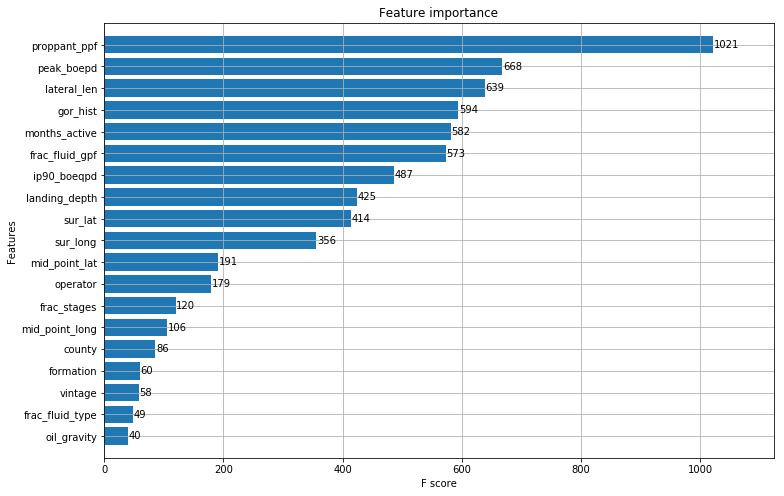

In [9]:
xgb_df = scaled_df.drop(columns=['recovery']).copy()

xgb_params = {
    'max_depth': 8,
    'seed' : 493
}
dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

## Test Harness and Options

For feature selection, drop the rows with nulls in them. (Tried to do this before xgboost, but it made xgboost crash.

In [10]:
scaled_df.isnull().sum()

proppant_ppf         0
frac_fluid_gpf       0
lateral_len          0
frac_stages        305
oil_gravity        154
peak_boepd           0
gor_hist             0
ip90_boeqpd          0
landing_depth        2
sur_lat              0
sur_long             0
mid_point_lat        0
mid_point_long       0
recovery             0
months_active        0
vintage              0
vintage_bin          0
county               0
frac_fluid_type      0
operator             0
type                 0
formation            0
dtype: int64

In [11]:
scaled_df.shape

(7882, 22)

In [12]:
scaled_df.dropna(inplace=True)

In [13]:
scaled_df.shape

(7437, 22)

In [14]:
scaled_df.isnull().sum()

proppant_ppf       0
frac_fluid_gpf     0
lateral_len        0
frac_stages        0
oil_gravity        0
peak_boepd         0
gor_hist           0
ip90_boeqpd        0
landing_depth      0
sur_lat            0
sur_long           0
mid_point_lat      0
mid_point_long     0
recovery           0
months_active      0
vintage            0
vintage_bin        0
county             0
frac_fluid_type    0
operator           0
type               0
formation          0
dtype: int64

#### Run the regression with all of the features:

MAE: 0.03529656746256977
MSE: 0.00894956850504309
lr.intercept: 0.009211429650799796


,value
mid_point_long,5.285149
mid_point_lat,1.313891
peak_boepd,0.830915
ip90_boeqpd,0.504777
months_active,0.418327
oil_gravity,0.101744
lateral_len,0.063288
gor_hist,0.047981
landing_depth,0.042876
formation,0.039820


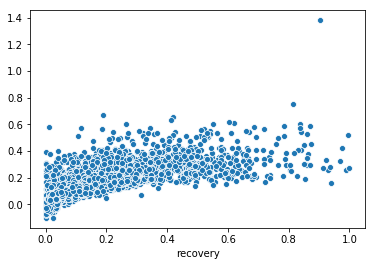

In [15]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'landing_depth',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 'months_active', 
       'vintage', 'vintage_bin', 'county', 'frac_fluid_type', 'operator', 'type', 
       'formation']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [16]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
sur_long,5.312568
mid_point_long,5.285149
mid_point_lat,1.313891
sur_lat,1.292000
peak_boepd,0.830915
ip90_boeqpd,0.504777
months_active,0.418327
oil_gravity,0.101744
vintage,0.092386
proppant_ppf,0.079406


Copied xgboost chart for comparison.

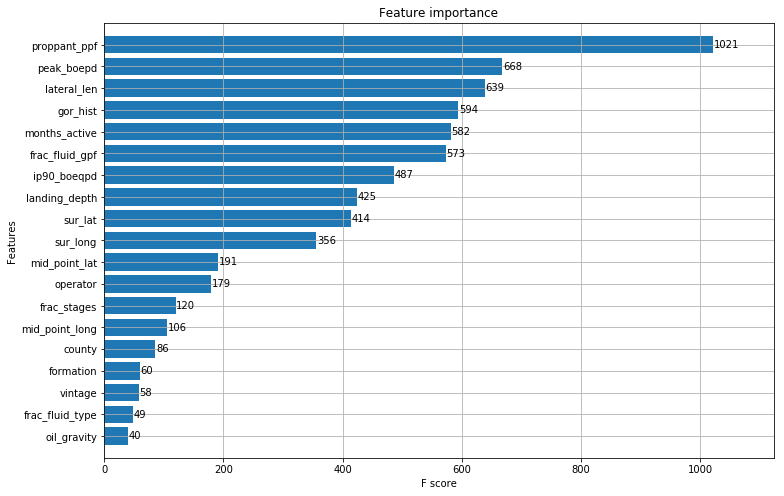

#### Filter for only vertical wells:

MAE: 0.00793864691645779
MSE: 0.0002451198657238174
lr.intercept: 0.040875014949144764


,value
sur_lat,117.834209
sur_long,20.057562
peak_boepd,1.932886
months_active,0.112922
lateral_len,0.111088
ip90_boeqpd,0.090189
landing_depth,0.014826
gor_hist,0.004248
frac_fluid_gpf,0.003837
vintage_bin,0.003767


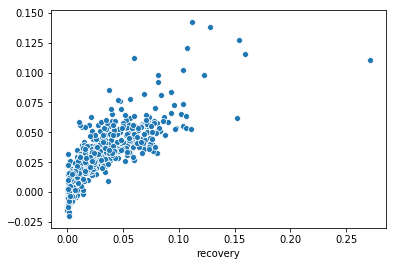

In [17]:
# Independent variables:
X_vars = ['proppant_ppf', 'frac_fluid_gpf', 'lateral_len', 'frac_stages',
       'oil_gravity', 'peak_boepd', 'gor_hist', 'ip90_boeqpd', 'landing_depth',
       'sur_lat', 'sur_long', 'mid_point_lat', 'mid_point_long', 'months_active', 
       'vintage', 'vintage_bin', 'county', 'frac_fluid_type', 'operator', 'type', 
       'formation']

# Dependent (target) variable, it is continuous
target = ['recovery']

# These lines are to filter for only vertical wells:
df_vert = scaled_df[scaled_df.type == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [18]:
print('ranked by absolute value of coefficient:')
abs_df.sort_values(by='value', ascending=False)

ranked by absolute value of coefficient:


,value
sur_lat,117.834209
mid_point_lat,117.797068
mid_point_long,20.081904
sur_long,20.057562
peak_boepd,1.932886
frac_stages,1.102493
months_active,0.112922
lateral_len,0.111088
ip90_boeqpd,0.090189
vintage,0.046056


#### Test only top features suggested by XGBoost (exclude peak_boepd), without filtering for vertical wells.

MAE: 0.03708356006121944
MSE: 0.010028265207764377
lr.intercept: -0.027908471111172894
reg_df:


,value
ip90_boeqpd,1.235689
months_active,0.440605
lateral_len,0.089148
gor_hist,0.074558
landing_depth,0.054935
sur_lat,0.041152
frac_fluid_gpf,0.026538
proppant_ppf,-0.037056
sur_long,-0.064691


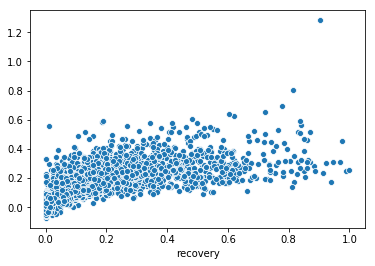

In [19]:
# Independent variables:
# X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
#           'months_active', 'lateral_len', 'ip90_boeqpd', 'county']
X_vars = ['proppant_ppf', 'lateral_len', 'gor_hist', 'months_active',
          'frac_fluid_gpf', 'ip90_boeqpd', 'landing_depth', 'sur_lat', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

X = scaled_df[X_vars].copy()                                                    
y = scaled_df[target]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
print('reg_df:')
reg_df

In [20]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
ip90_boeqpd,1.235689
months_active,0.440605
lateral_len,0.089148
gor_hist,0.074558
sur_long,0.064691
landing_depth,0.054935
sur_lat,0.041152
proppant_ppf,0.037056
frac_fluid_gpf,0.026538


#### Test only top features suggested by XGBoost (exclude peak_boepd), WITH filtering for vertical wells.

MAE: 0.00819869213792147
MSE: 0.00026662002565360784
lr.intercept: 0.013683808286308174
reg_df:


,value
ip90_boeqpd,2.057810
months_active,0.129233
lateral_len,0.105623
landing_depth,0.011100
sur_lat,0.008102
frac_fluid_gpf,0.006453
gor_hist,0.006166
proppant_ppf,0.001234
sur_long,-0.037128


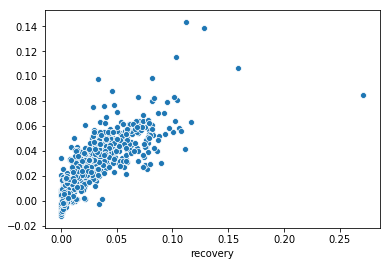

In [21]:
# Independent variables:
# X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
#           'months_active', 'lateral_len', 'ip90_boeqpd', 'county']
X_vars = ['proppant_ppf', 'lateral_len', 'gor_hist', 'months_active',
          'frac_fluid_gpf', 'ip90_boeqpd', 'landing_depth', 'sur_lat', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.type == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
print('reg_df:')
reg_df

In [22]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
ip90_boeqpd,2.057810
months_active,0.129233
lateral_len,0.105623
sur_long,0.037128
landing_depth,0.011100
sur_lat,0.008102
frac_fluid_gpf,0.006453
gor_hist,0.006166
proppant_ppf,0.001234


#### Run with features Joseph selected, with filtering for vertical wells:

MAE: 0.011630392579803221
MSE: 0.0004872503477089481
lr.intercept: 0.12793109411300227


,value
lateral_len,0.209389
sur_lat,0.040824
landing_depth,0.035438
proppant_ppf,0.028950
oil_gravity,-0.016011
sur_long,-0.071599
vintage,-0.109125
frac_stages,-0.958064


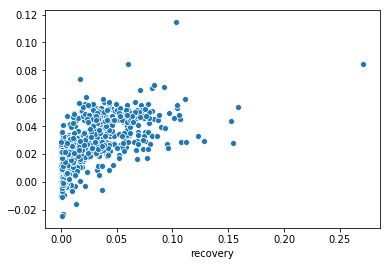

In [23]:
# Independent variables:
X_vars = ['lateral_len', 'proppant_ppf', 'frac_stages', 'vintage', 
          'oil_gravity', 'landing_depth', 'sur_lat', 'sur_long']

# Dependent (target) variable, it is continuous
target = ['recovery']

df_vert = scaled_df[scaled_df.type == 1.0]
df_vert.dropna(inplace=True)

X = df_vert[X_vars].copy()                                                    
y = df_vert[['recovery']]

# random_state=0 tells the sklearn function that you are not setting a seed
# if you want to be able to duplicate results, set random_state to a positive integer
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

reg_df, abs_df, lr, lr.coef_, lr.intercept_, MAE, MSE, y_pred, scatter = linreg(X_train, y_train)
print('MAE:', MAE)
print('MSE:', MSE)
print('lr.intercept:', lr.intercept_[0])
reg_df

In [24]:
print('abs_df:')
abs_df.sort_values(by='value', ascending=False)

abs_df:


,value
frac_stages,0.958064
lateral_len,0.209389
vintage,0.109125
sur_long,0.071599
sur_lat,0.040824
landing_depth,0.035438
proppant_ppf,0.028950
oil_gravity,0.016011


# Need to add filter_columns for the following to work.

## Explore and select algorithms

In [ ]:
def lregressiontest(df,xfeatures,yfeature,train_size):
    y = df[yfeature]
    X = filter_columns(df,xfeatures)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    column_names = X_train.columns
    r_and_p_values = [pearsonr(X_train[col], y_train) for col in column_names]
    corrdict = dict(zip(column_names, r_and_p_values))

    ols_model = sm.OLS(y_train, X_train)
    fit = ols_model.fit()
    lm1 = LinearRegression(fit_intercept=False) 
    lm1.fit(X_train[xfeatures], y_train)
    LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
    lm1_y_intercept = lm1.intercept_
    lm1_coefficients = lm1.coef_
    y_pred_lm1 = lm1.predict(X_train[xfeatures])
    mse = mean_squared_error(y_train, y_pred_lm1)
    r2 = r2_score(y_train, y_pred_lm1)
    return mse, r2, corrdict


In [ ]:
X_vars = ['proppant_ppf', 'gor_hist', 'frac_fluid_gpf', 
          'months_active', 'lateral_len', 'ip90_boeqpd', 'county']

lregressiontest(scaled_df, X_vars, 'recovery', .8)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering